In [13]:
import torch
import yaml
import time
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
from torch_ema import ExponentialMovingAverage

from models.state_mlp import StateMLP, ProjectToTangent, WrappedVF
from data.lasa_data import StatePyLASADataset, wrap
from utils.plotting import plot_flow_on_sphere, plot_3d_points
from utils.manifold_utils import infer_model, step

from flow_matching.utils.manifolds import Manifold, Sphere
from flow_matching.path import GeodesicProbPath
from flow_matching.path.scheduler import CondOTScheduler

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from soft_dtw import SoftDTW

In [2]:
torch.manual_seed(3420934659826)

In [3]:
run_parameters =  yaml.safe_load(Path("./configs/general.yaml").read_text())
run_parameters

{'lr': 0.0001,
 'epochs': 30001,
 'batch_size': 1200,
 'inf_every': 2000,
 'print_every': 500,
 'dim': 3,
 'hidden_dim': 64,
 'horizon_size': 8,
 'inference_horizon': 4,
 'scale_factor': 3.0,
 'downsample': 5,
 'mean': 0.0,
 'std': 1.2,
 'ema_warmup': 1000,
 'ema_update': 5,
 'ema_decay': 0.999,
 'inf_runs_num': 3,
 'save_epoch': 6000,
 'device': 'cpu',
 'manifold': 'Sphere'}

In [4]:
manifold_types = {'None' : None, 'Sphere':Sphere()}

In [5]:
manifold = manifold_types[run_parameters['manifold']]

sine_data = StatePyLASADataset("Sine", horizon_size=run_parameters['horizon_size'],
                                       scaling_factor=run_parameters['scale_factor'],
                                       downsample = run_parameters['downsample'],
                                       manifold=manifold)

train_dataset = torch.utils.data.Subset(sine_data, range(6000//run_parameters['downsample']))

test_dataset = torch.utils.data.Subset(sine_data, range(6000//run_parameters['downsample'], 
                                                        7000//run_parameters['downsample']))

train_sin = DataLoader(train_dataset,
                       batch_size=run_parameters['batch_size'],
                       shuffle=True)

val_sin = DataLoader(test_dataset,
                    batch_size=run_parameters['batch_size'],
                    shuffle=True)

test_sin = DataLoader(test_dataset,
                    batch_size=1,
                    shuffle=False)

inf_obs, _ = next(iter(test_sin))
inf_obs = inf_obs[:, :2]

gt_test = DataLoader(test_dataset,
                    batch_size=1000//run_parameters['downsample'],
                    shuffle=False)

gt_obs, gt_horizon = next(iter(gt_test))

In [8]:
vf = StateMLP(
    action_dim=run_parameters['dim'],
    hidden_dim=run_parameters['hidden_dim'],
    horizon_size=run_parameters['horizon_size'],
)

ema_vf = ExponentialMovingAverage(
    vf.parameters(),
    decay = run_parameters['ema_decay'],
)

model_parameters = filter(lambda p: p.requires_grad, vf.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Learnable param number:", params)

Learnable param number: 42032


In [15]:
vf.load_state_dict(torch.load("./vf_3d3.0.pth", weights_only=True))
ema_vf = ExponentialMovingAverage(
    vf.parameters(),
    decay = run_parameters['ema_decay'],
)

# run_parameters['lr'] = 1e-5
run_parameters['epochs'] = 30001

| iter      0 |  0.08 ms/step | train loss    0.066 
| iter      0 | validation loss:    0.072 


  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:02<00:00, 23.29it/s]


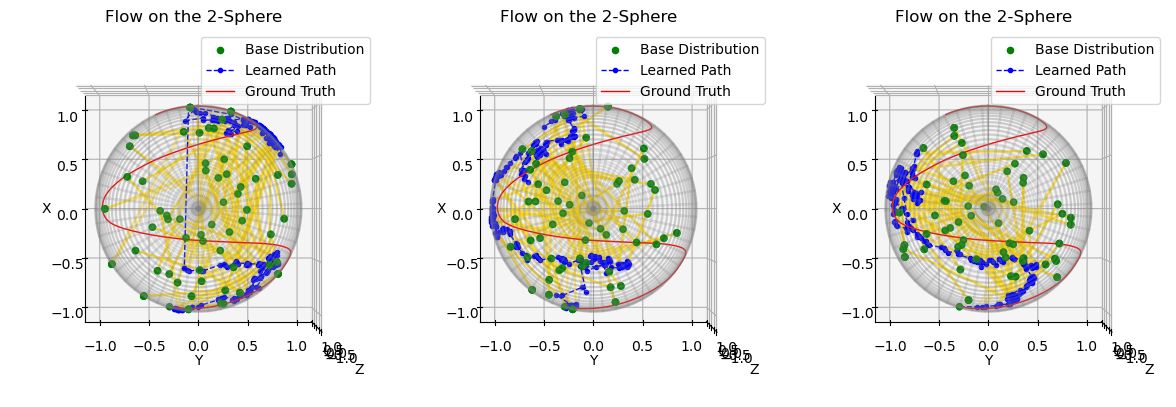

| iter    500 | 41.55 ms/step | train loss    0.060 
| iter    500 | validation loss:    0.055 
| iter   1000 | 24.62 ms/step | train loss    0.061 
| iter   1000 | validation loss:    0.074 
| iter   1500 | 23.64 ms/step | train loss    0.063 
| iter   1500 | validation loss:    0.060 
| iter   2000 | 24.59 ms/step | train loss    0.062 
| iter   2000 | validation loss:    0.056 


100%|██████████| 60/60 [00:02<00:00, 24.05it/s]


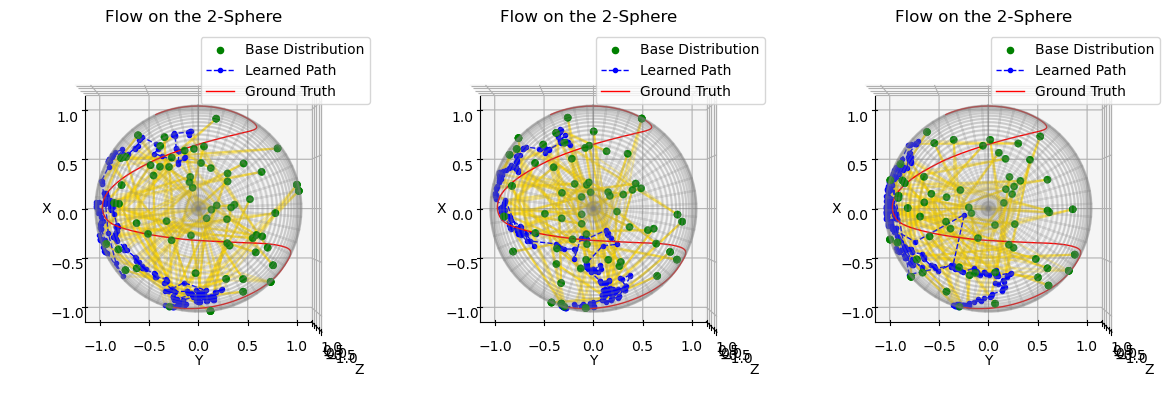

| iter   2500 | 38.26 ms/step | train loss    0.056 
| iter   2500 | validation loss:    0.071 
| iter   3000 | 22.40 ms/step | train loss    0.059 
| iter   3000 | validation loss:    0.049 
| iter   3500 | 21.47 ms/step | train loss    0.054 
| iter   3500 | validation loss:    0.067 
| iter   4000 | 22.52 ms/step | train loss    0.055 
| iter   4000 | validation loss:    0.060 


100%|██████████| 60/60 [00:02<00:00, 23.97it/s]


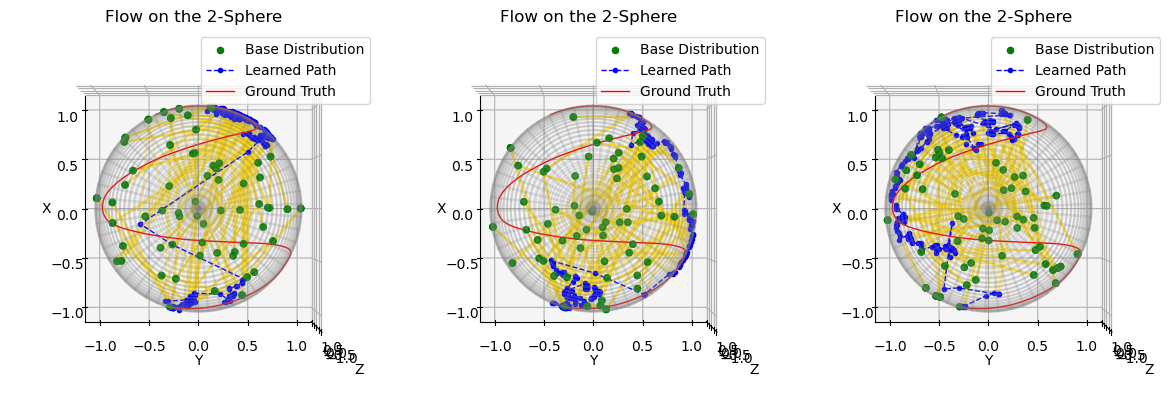

| iter   4500 | 40.58 ms/step | train loss    0.056 
| iter   4500 | validation loss:    0.047 
| iter   5000 | 23.48 ms/step | train loss    0.060 
| iter   5000 | validation loss:    0.061 
| iter   5500 | 24.31 ms/step | train loss    0.050 
| iter   5500 | validation loss:    0.061 
| iter   6000 | 23.56 ms/step | train loss    0.060 
| iter   6000 | validation loss:    0.059 


100%|██████████| 60/60 [00:02<00:00, 22.71it/s]


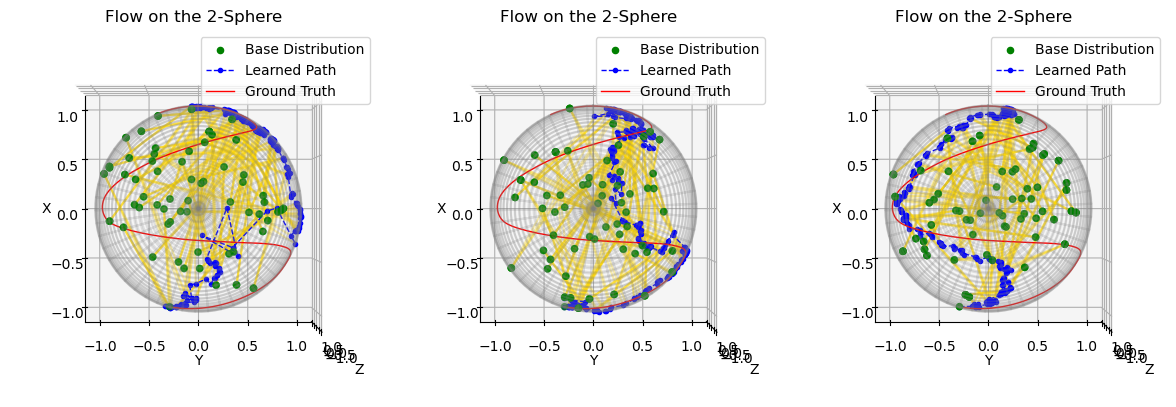

| iter   6500 | 1095.11 ms/step | train loss    0.050 
| iter   6500 | validation loss:    0.067 
| iter   7000 | 23.68 ms/step | train loss    0.049 
| iter   7000 | validation loss:    0.066 
| iter   7500 | 24.48 ms/step | train loss    0.053 
| iter   7500 | validation loss:    0.054 
| iter   8000 | 24.70 ms/step | train loss    0.051 
| iter   8000 | validation loss:    0.051 


100%|██████████| 60/60 [00:02<00:00, 23.29it/s]


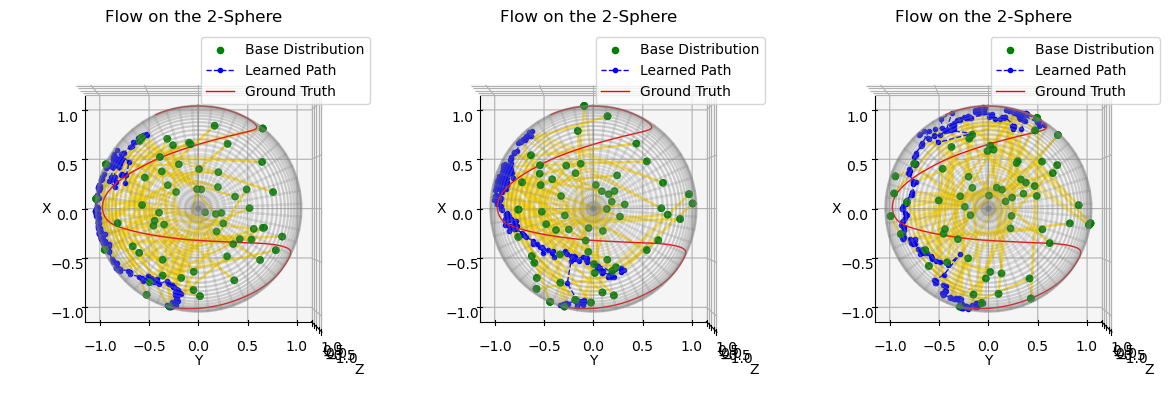

| iter   8500 | 41.06 ms/step | train loss    0.046 
| iter   8500 | validation loss:    0.040 
| iter   9000 | 25.97 ms/step | train loss    0.049 
| iter   9000 | validation loss:    0.049 
| iter   9500 | 24.49 ms/step | train loss    0.045 
| iter   9500 | validation loss:    0.041 
| iter  10000 | 24.09 ms/step | train loss    0.048 
| iter  10000 | validation loss:    0.051 


100%|██████████| 60/60 [00:02<00:00, 24.22it/s]


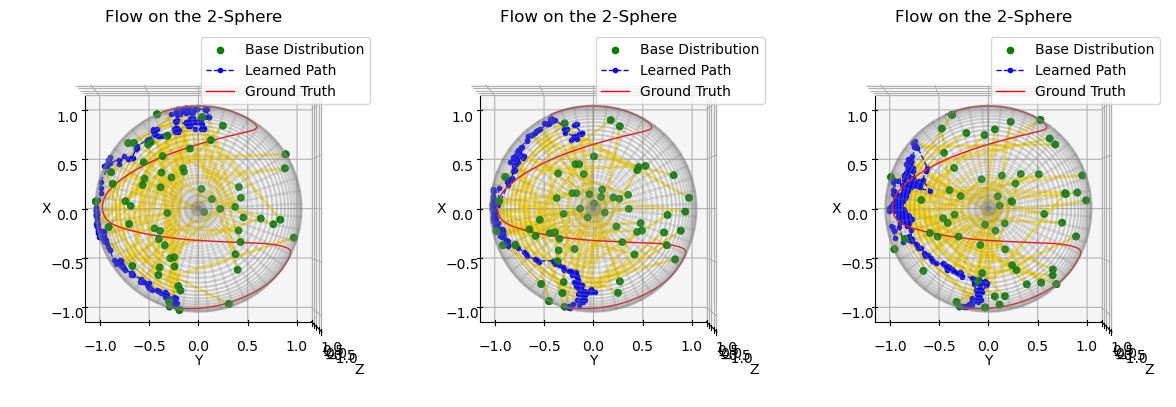

| iter  10500 | 40.99 ms/step | train loss    0.049 
| iter  10500 | validation loss:    0.039 
| iter  11000 | 24.37 ms/step | train loss    0.047 
| iter  11000 | validation loss:    0.043 
| iter  11500 | 23.61 ms/step | train loss    0.043 
| iter  11500 | validation loss:    0.056 
| iter  12000 | 25.55 ms/step | train loss    0.046 
| iter  12000 | validation loss:    0.064 


100%|██████████| 60/60 [00:02<00:00, 23.48it/s]


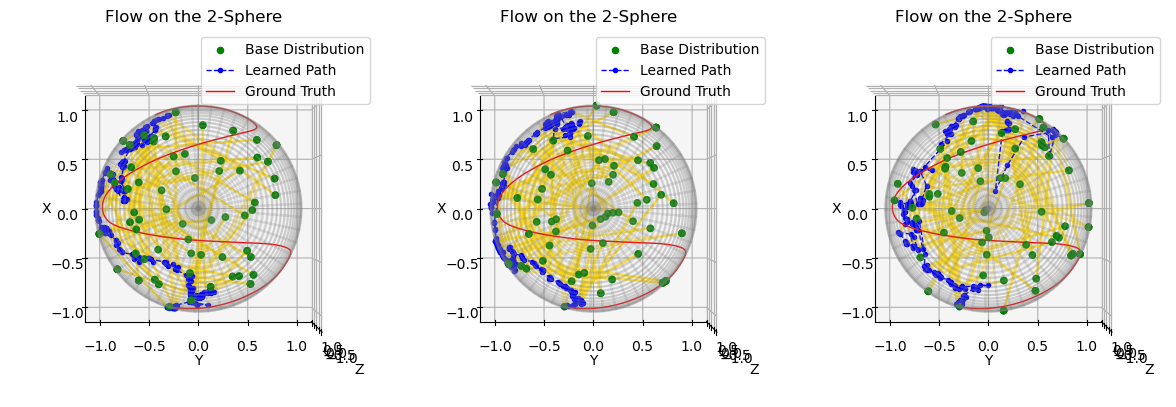

| iter  12500 | 41.17 ms/step | train loss    0.046 
| iter  12500 | validation loss:    0.044 
| iter  13000 | 23.39 ms/step | train loss    0.042 
| iter  13000 | validation loss:    0.060 
| iter  13500 | 23.62 ms/step | train loss    0.047 
| iter  13500 | validation loss:    0.045 
| iter  14000 | 23.20 ms/step | train loss    0.042 
| iter  14000 | validation loss:    0.050 


100%|██████████| 60/60 [00:02<00:00, 24.60it/s]


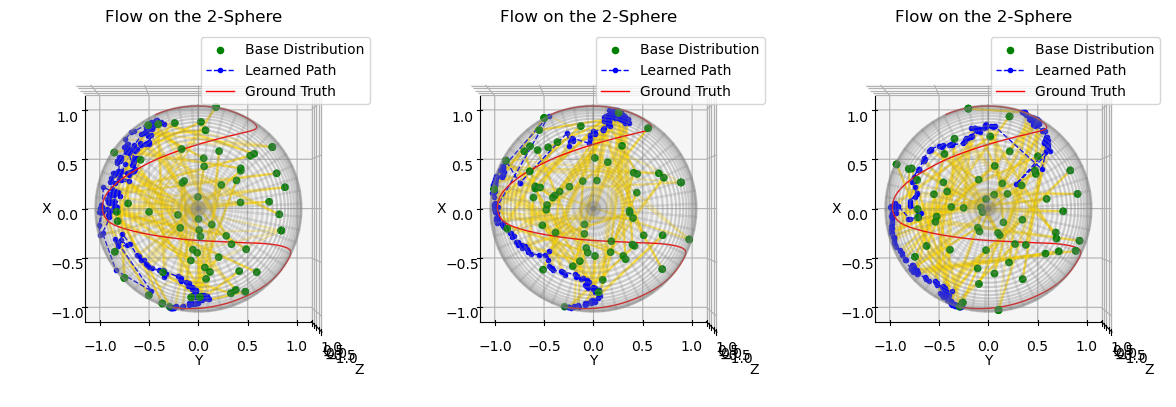

| iter  14500 | 38.57 ms/step | train loss    0.051 
| iter  14500 | validation loss:    0.054 
| iter  15000 | 21.60 ms/step | train loss    0.050 
| iter  15000 | validation loss:    0.045 
| iter  15500 | 22.91 ms/step | train loss    0.037 
| iter  15500 | validation loss:    0.047 
| iter  16000 | 23.19 ms/step | train loss    0.044 
| iter  16000 | validation loss:    0.039 


100%|██████████| 60/60 [00:02<00:00, 23.64it/s]


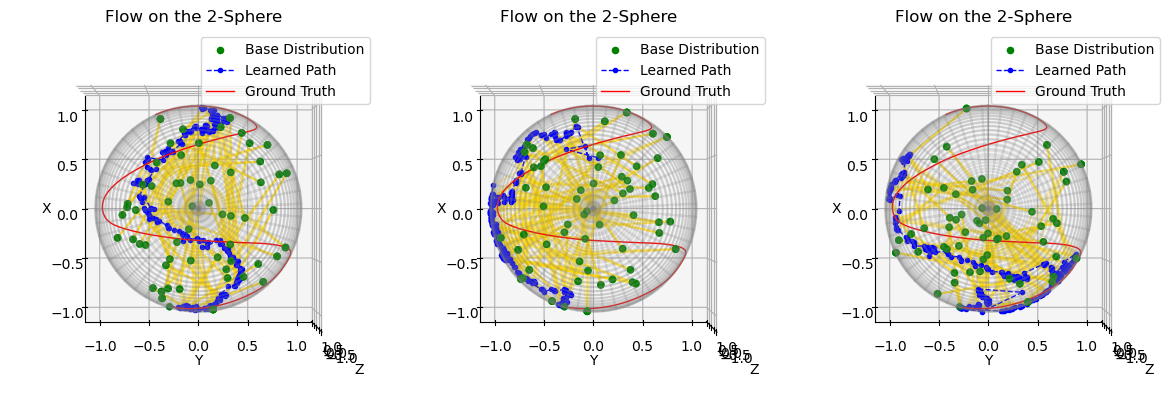

| iter  16500 | 41.33 ms/step | train loss    0.042 
| iter  16500 | validation loss:    0.055 
| iter  17000 | 23.50 ms/step | train loss    0.045 
| iter  17000 | validation loss:    0.040 
| iter  17500 | 23.60 ms/step | train loss    0.041 
| iter  17500 | validation loss:    0.037 
| iter  18000 | 23.50 ms/step | train loss    0.048 
| iter  18000 | validation loss:    0.039 


100%|██████████| 60/60 [00:02<00:00, 24.46it/s]


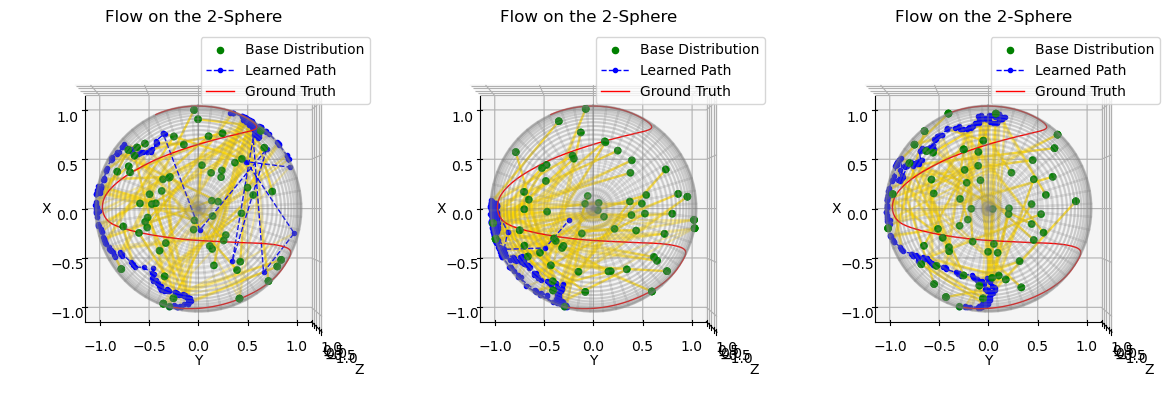

| iter  18500 | 40.14 ms/step | train loss    0.041 
| iter  18500 | validation loss:    0.048 
| iter  19000 | 23.34 ms/step | train loss    0.039 
| iter  19000 | validation loss:    0.051 
| iter  19500 | 23.78 ms/step | train loss    0.045 
| iter  19500 | validation loss:    0.049 
| iter  20000 | 23.64 ms/step | train loss    0.039 
| iter  20000 | validation loss:    0.041 


100%|██████████| 60/60 [00:02<00:00, 22.49it/s]


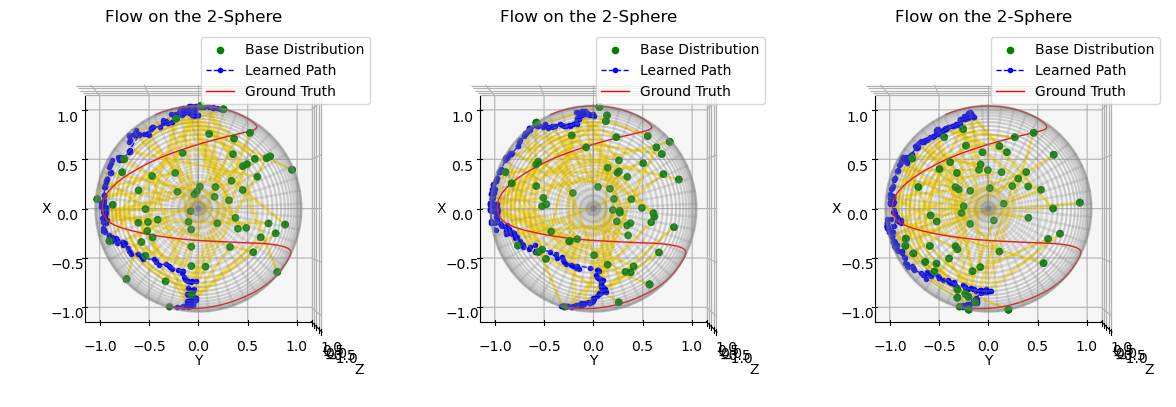

| iter  20500 | 41.20 ms/step | train loss    0.041 
| iter  20500 | validation loss:    0.050 
| iter  21000 | 23.18 ms/step | train loss    0.040 
| iter  21000 | validation loss:    0.055 
| iter  21500 | 23.21 ms/step | train loss    0.048 
| iter  21500 | validation loss:    0.044 
| iter  22000 | 23.17 ms/step | train loss    0.033 
| iter  22000 | validation loss:    0.031 


100%|██████████| 60/60 [00:02<00:00, 24.66it/s]


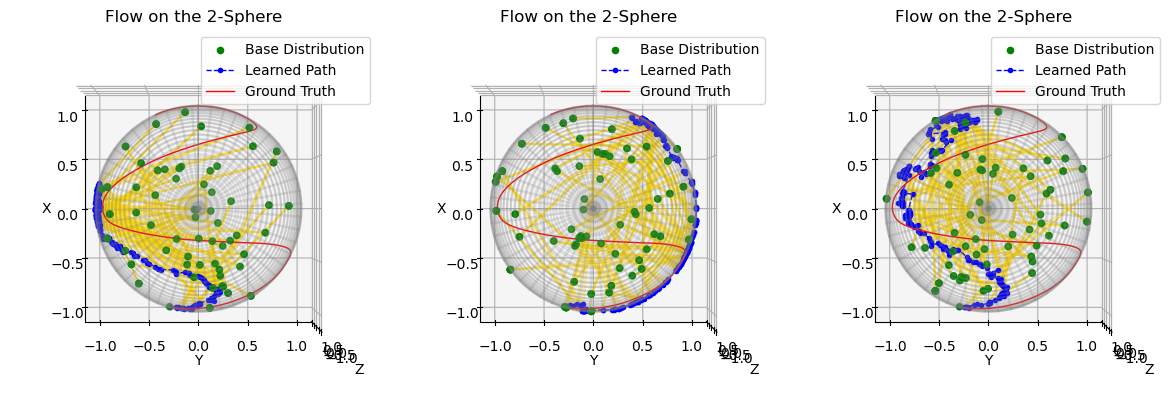

| iter  22500 | 40.49 ms/step | train loss    0.038 
| iter  22500 | validation loss:    0.041 
| iter  23000 | 23.08 ms/step | train loss    0.034 
| iter  23000 | validation loss:    0.044 
| iter  23500 | 23.33 ms/step | train loss    0.032 
| iter  23500 | validation loss:    0.052 
| iter  24000 | 24.02 ms/step | train loss    0.042 
| iter  24000 | validation loss:    0.035 


100%|██████████| 60/60 [00:02<00:00, 23.57it/s]


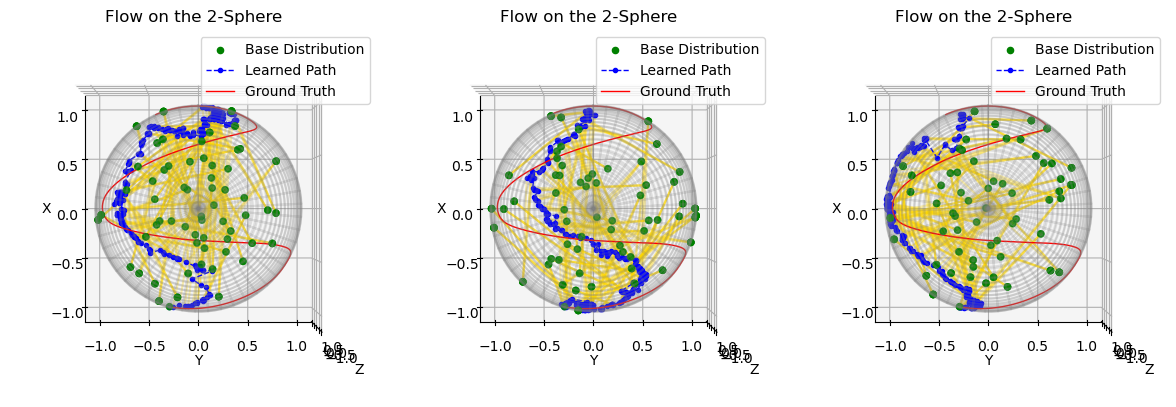

| iter  24500 | 39.53 ms/step | train loss    0.032 
| iter  24500 | validation loss:    0.039 
| iter  25000 | 23.83 ms/step | train loss    0.035 
| iter  25000 | validation loss:    0.043 
| iter  25500 | 23.57 ms/step | train loss    0.035 
| iter  25500 | validation loss:    0.030 
| iter  26000 | 23.12 ms/step | train loss    0.033 
| iter  26000 | validation loss:    0.029 


100%|██████████| 60/60 [00:02<00:00, 24.47it/s]


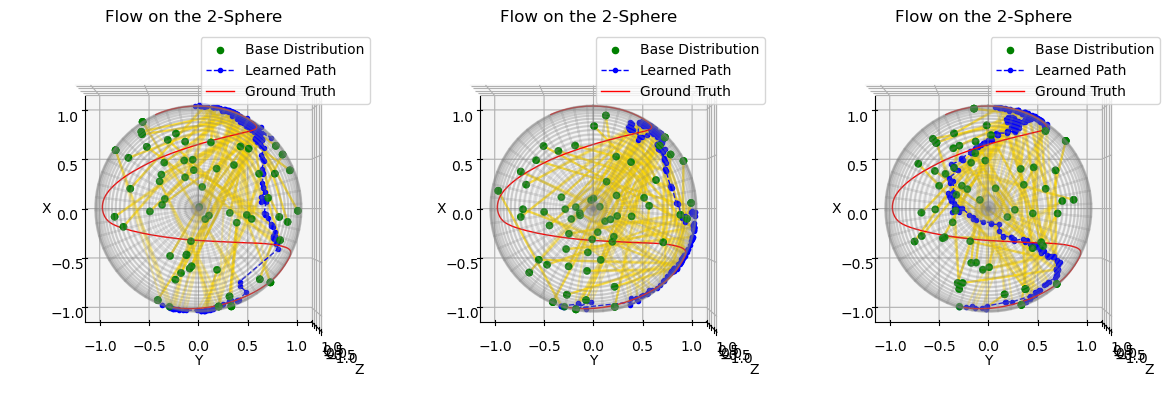

| iter  26500 | 37.87 ms/step | train loss    0.043 
| iter  26500 | validation loss:    0.036 
| iter  27000 | 22.06 ms/step | train loss    0.032 
| iter  27000 | validation loss:    0.038 
| iter  27500 | 21.44 ms/step | train loss    0.034 
| iter  27500 | validation loss:    0.031 
| iter  28000 | 21.95 ms/step | train loss    0.037 
| iter  28000 | validation loss:    0.040 


100%|██████████| 60/60 [00:02<00:00, 24.93it/s]


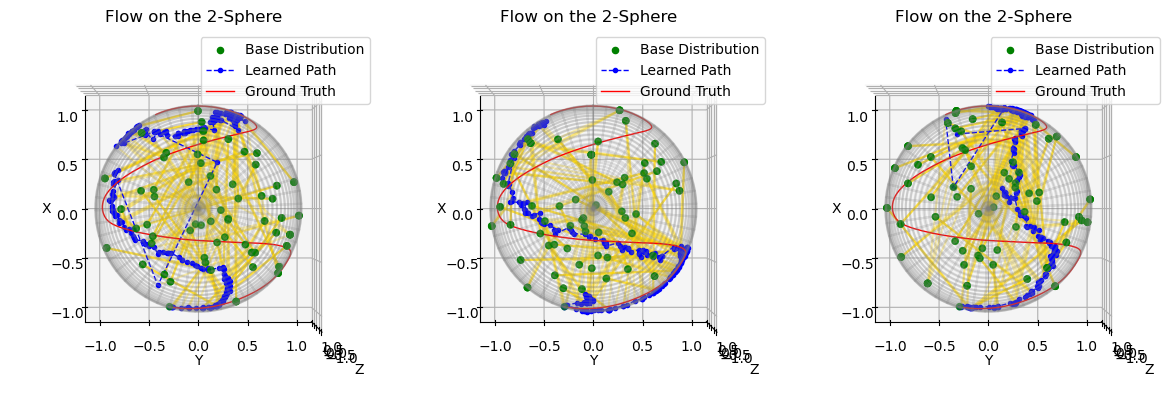

| iter  28500 | 39.53 ms/step | train loss    0.038 
| iter  28500 | validation loss:    0.032 
| iter  29000 | 23.41 ms/step | train loss    0.035 
| iter  29000 | validation loss:    0.031 
| iter  29500 | 23.47 ms/step | train loss    0.030 
| iter  29500 | validation loss:    0.040 
| iter  30000 | 22.91 ms/step | train loss    0.036 
| iter  30000 | validation loss:    0.030 


100%|██████████| 60/60 [00:02<00:00, 25.27it/s]


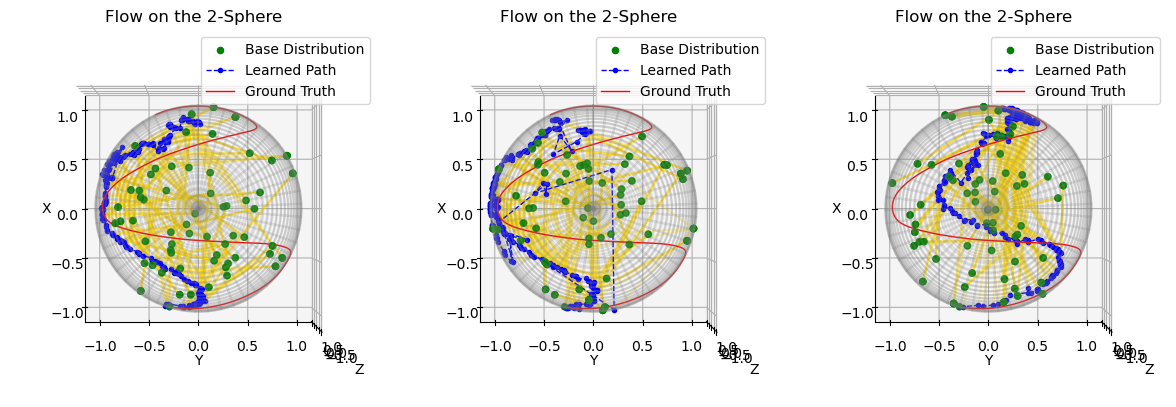

In [16]:
device = run_parameters['device']
vf.to(device)

optim = torch.optim.Adam(vf.parameters(), lr=run_parameters['lr'])

path = GeodesicProbPath(scheduler=CondOTScheduler(), manifold=manifold)

start_time = time.time()
for i in range(run_parameters['epochs']):
  for batch in train_sin:
    optim.zero_grad()

    train_loss = step(vf=vf, 
                      batch=batch, 
                      run_parameters=run_parameters, 
                      manifold=manifold, 
                      path=path, 
                      device=device)
    
    train_loss.backward()
    optim.step()

    if i > run_parameters['ema_warmup'] and i % run_parameters['ema_update'] == 0: 
      ema_vf.update()

    if i % run_parameters['print_every'] == 0:
      elapsed = time.time() - start_time
      print('| iter {:6d} | {:5.2f} ms/step | train loss {:8.3f} '
            .format(i, elapsed*1000/run_parameters['print_every'], train_loss.item()))
      
      with torch.no_grad():
        ema_vf.store()
        ema_vf.copy_to()
        loss_val = step(vf=vf, 
                        batch=next(iter(val_sin)), 
                        run_parameters=run_parameters, 
                        manifold=manifold, 
                        path=path, 
                        device=device)
        ema_vf.restore()
        print('| iter {:6d} | validation loss: {:8.3f} '.format(i, loss_val))
      start_time = time.time()

    if i % run_parameters['inf_every'] == 0:
        with torch.no_grad():
            results = []
            samples = []
            ema_vf.store()
            ema_vf.copy_to()
            for _ in range(run_parameters['inf_runs_num']):
                res, samp = infer_model(model=vf, 
                                start=gt_obs[0,:run_parameters['dim']], 
                                manifold=manifold,
                                model_horizon=run_parameters['horizon_size'],
                                inference_horizon=run_parameters['inference_horizon'],
                                sample_points=run_parameters['batch_size'] // run_parameters['downsample'],
                                mean=run_parameters['mean'],
                                std=run_parameters['std'])
                results.append(res)
                samples.append(samp)
            ema_vf.restore()
            plot_flow_on_sphere(results, samples, gt_obs)


In [12]:
torch.save(vf.state_dict(), "./vf_3d" + str(run_parameters['scale_factor']) + ".pth")

In [8]:
vf.load_state_dict(torch.load("./vf_3d2.0_30000.pth", weights_only=True))
vf.eval()

StateMLP(
  (model): SequentialDiffEq(
    (layers): ModuleList(
      (0): ConcatLinear_v2(
        (_layer): Linear(in_features=31, out_features=64, bias=True)
        (_hyper_bias): Linear(in_features=1, out_features=64, bias=False)
      )
      (1): TimeDependentSwish(
        (beta): Sequential(
          (0): Linear(in_features=1, out_features=64, bias=True)
          (1): Softplus(beta=1.0, threshold=20.0)
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): Softplus(beta=1.0, threshold=20.0)
        )
      )
      (2): ConcatLinear_v2(
        (_layer): Linear(in_features=64, out_features=64, bias=True)
        (_hyper_bias): Linear(in_features=1, out_features=64, bias=False)
      )
      (3): TimeDependentSwish(
        (beta): Sequential(
          (0): Linear(in_features=1, out_features=64, bias=True)
          (1): Softplus(beta=1.0, threshold=20.0)
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): Softplus(beta=

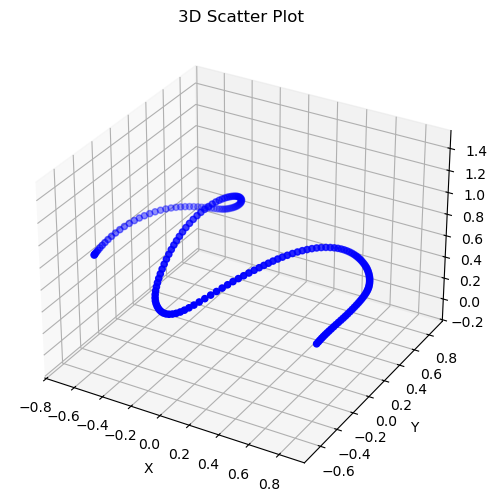

In [8]:
plot_3d_points(gt_obs[:, :3])

In [10]:
criterion =  SoftDTW(gamma=1.0, normalize=True)

100%|██████████| 60/60 [00:02<00:00, 24.65it/s]


tensor(0.5075)


100%|██████████| 60/60 [00:02<00:00, 26.06it/s]


tensor(0.2997)


100%|██████████| 60/60 [00:02<00:00, 26.12it/s]


tensor(0.4987)


100%|██████████| 60/60 [00:02<00:00, 25.94it/s]


tensor(0.6362)


100%|██████████| 60/60 [00:02<00:00, 25.32it/s]


tensor(0.3920)


100%|██████████| 60/60 [00:02<00:00, 25.61it/s]


tensor(0.2418)


100%|██████████| 60/60 [00:02<00:00, 25.91it/s]


tensor(0.3369)


100%|██████████| 60/60 [00:02<00:00, 25.57it/s]


tensor(1.2240)


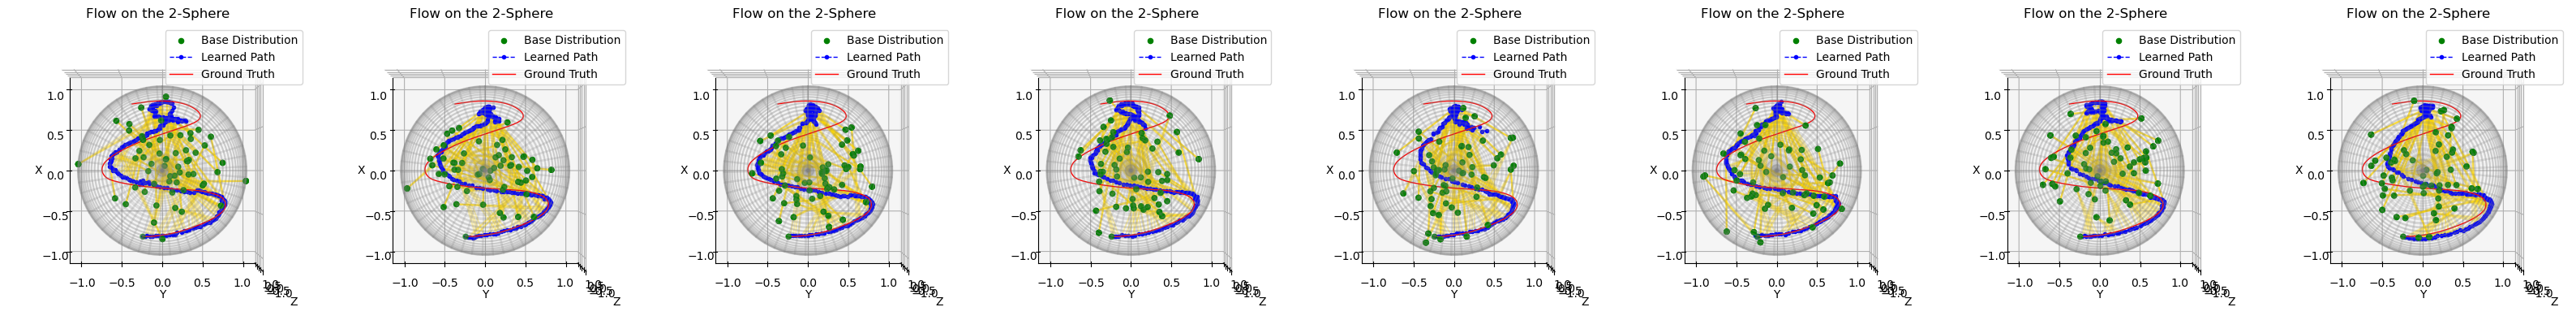

In [11]:
results = []
samples = []
for _ in range(8):
    res, samp = infer_model(model=vf, 
                    start=gt_obs[0,:run_parameters['dim']], 
                    manifold=manifold,
                    model_horizon=run_parameters['horizon_size'],
                    inference_horizon=run_parameters['inference_horizon'],
                    sample_points=int(run_parameters['batch_size'] // run_parameters['downsample']),
                    mean=run_parameters['mean'],
                    std=run_parameters['std'],
                    step_size=0.01)
    results.append(res)
    samples.append(samp)
    loss = criterion(gt_obs[:50, :3], res[:50])
    print(loss)
plot_flow_on_sphere(results, samples, gt_obs)

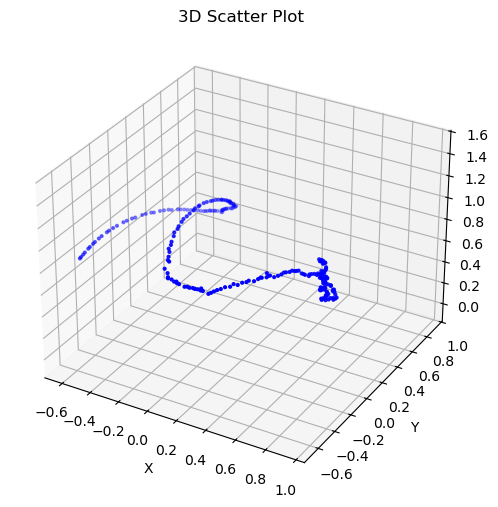

In [18]:
plot_3d_points(results[4], s=4)

In [11]:
def plot_points(points, 
                title="3D Scatter Plot", 
                color="blue", 
                s=20, 
                show_grid=True,
                elev=0,
                azim=0):
    if isinstance(points, torch.Tensor):
        points = points.cpu().numpy()  # Convert from PyTorch to NumPy if needed

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")

   # print(points.shape)

    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color=color, s=s)

    # Labels and title
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(title)

    # Optional grid
    ax.grid(show_grid)

    # Set equal aspect ratio
    max_range = (points.max() - points.min()) / 2
    mid = points.mean(axis=0)
    # ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    # ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    # ax.set_zlim(mid[2] - max_range, mid[2] + max_range)

    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 50)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(x, y, z, color="gray", alpha=0.2)

    # Adjust view to center the north pole
    ax.view_init(elev=elev, azim=azim)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Flow on the 2-Sphere")
    
    plt.tight_layout()
    # Interactive rotation
    plt.show()

In [12]:
results_euc = torch.load('euclidean_inference.pt', weights_only=True)
samples_euc = torch.load('euclidean_samples.pt', weights_only=True)

In [13]:
results_euc_proj = wrap(manifold=manifold, samples=results_euc[0])
samples_euc_proj = wrap(manifold=manifold, samples=samples_euc[0])

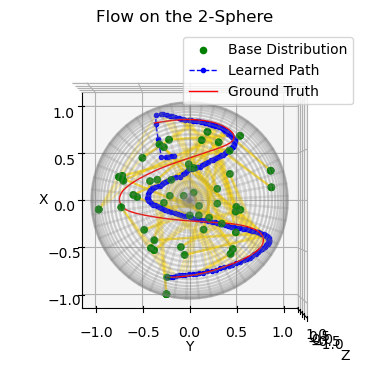

In [14]:
plot_flow_on_sphere(results_list=[results_euc_proj], samples_list=[samples_euc_proj], gt_samples=gt_obs)

In [15]:
print(criterion(results_euc_proj[:50], gt_obs[1:50,:3]))

tensor(0.6719)
